In [1]:
import fmpy
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
%matplotlib inline

In [2]:
# Set the comparison for dymola results
dymolaComparisons = ['non-fmu-all','fmu-all','non-fmu','fmu']
dymolaComparison = dymolaComparisons[3]
dpi = 300

In [3]:
# Create plot directory
plotDirectory = 'plots'
plotPath = plotDirectory
if os.path.exists(plotPath):
    shutil.rmtree(plotPath)

os.makedirs(plotPath)  
for key in dymolaComparisons:
    os.makedirs(os.path.join(plotPath,key)) 

# FMpy Library

In [4]:
fmu_tests = ['Connectors','Inputs','Parameters']
fmu_test = fmu_tests[0]
fmu_path = '../FMUs/' + fmu_test + '/'
fmu = fmu_path + 'FMIRaven_Models_LorenzSystem_' + fmu_test + '.fmu'

In [5]:
fmpy.dump(fmu)


Model Info

  FMI Version       2.0
  FMI Type          Co-Simulation
  Model Name        FMIRaven_Models_LorenzSystem_Connectors
  Description       None
  Platforms         win32, win64
  Continuous States 3
  Event Indicators  0
  Variables         12
  Generation Tool   Dymola Version 2020x (64-bit), 2019-10-10 (using Dassl with tolerance 0.0001)
  Generation Date   2020-02-28T18:52:35Z

Default Experiment

  Stop Time         100
  Tolerance         0.0001

Variables (input, output)

Name                Causality              Start Value  Unit     Description
sigma               input                          0.0           
rho                 input                          0.0           
beta                input                          0.0           


In [6]:
model_description = fmpy.read_model_description(fmu)

In [7]:
vrs = []
for variable in model_description.modelVariables:
        vrs.append(variable.name)

In [8]:
vrs

['x_start',
 'y_start',
 'z_start',
 'x',
 'der(x)',
 'y',
 'der(y)',
 'z',
 'der(z)',
 'sigma',
 'rho',
 'beta']

In [9]:
outputs=['x','y','z','sigma','beta','rho']
start_values={'sigma':10,'rho':28,'beta':8/3}
inputs = np.genfromtxt('input_test.txt', delimiter=',', names=True)
result = fmpy.simulate_fmu(fmu,output=outputs,start_values=start_values)#,input=inputs)         # simulate the FMU

[OK] FMIRaven_Models_LorenzSystem_Connectors started

[OK] results will NOT be written since no file given.

[OK] 
Integration started at T = 0 using integration method DASSL
(DAE multi-step solver (dassl/dasslrt of Petzold modified by Dassault Systemes))

[OK] Integration terminated successfully at T = 100

[OK]    CPU-time for integration                : 0.015 seconds

[OK]    CPU-time for one grid interval          : 0.03 milliseconds

[OK]    CPU-time for initialization             : 0.001 seconds

[OK]    Number of result points                 : 501

[OK]    Number of grid points                   : 501

[OK]    Number of accepted steps                : 6576

[OK]    Number of f-evaluations (dynamics)      : 13503

[OK]    Number of Jacobian-evaluations          : 202

[OK]    Number of model time events             : 0

[OK]    Number of input time events             : 0

[OK]    Number of state events                  : 0

[OK]    Number of step events                   : 0

[

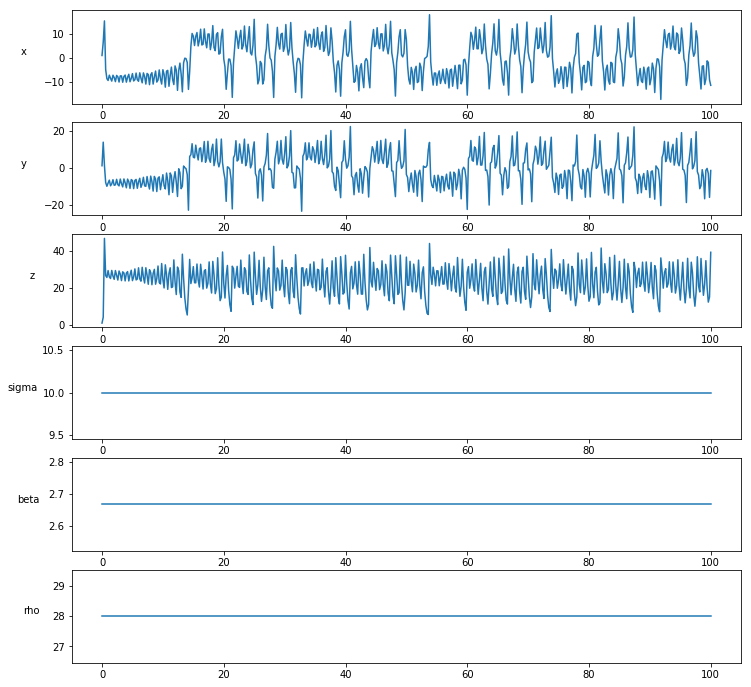

In [10]:
from fmpy.util import plot_result  # import the plot function
# plot_result(result,names=outputs)

fig, ax = plt.subplots(len(outputs),1,figsize=[12,12])
for i, v in enumerate(outputs):
    ax[i].plot(result['time'],result[v])
    ax[i].set_ylabel(v,rotation=0,labelpad=20)
    
fig.savefig(plotPath+'/{}/{}_fmpy.png'.format(dymolaComparison,fmu_test),dpi=dpi)

# pyFMI Library

In [11]:
from pyfmi import load_fmu
model = load_fmu(fmu)
model.set('sigma',10)
model.set('beta',8/3)
model.set('rho',28)
res_pyfmi = model.simulate()

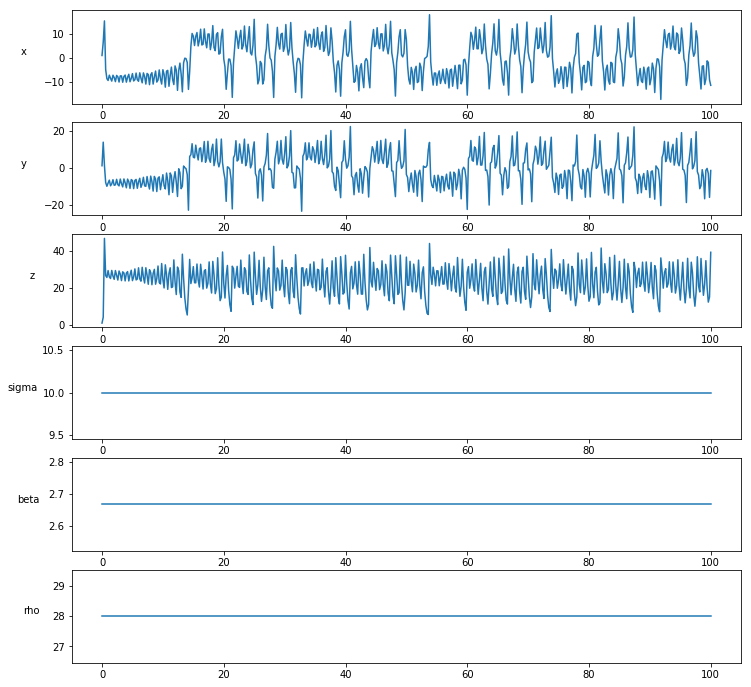

In [12]:
fig, ax = plt.subplots(len(outputs),1,figsize=[12,12])
for i, v in enumerate(outputs):
    ax[i].plot(res_pyfmi['time'],res_pyfmi[v])
    ax[i].set_ylabel(v,rotation=0,labelpad=20)
    
fig.savefig(plotPath+'/{}/{}_pyfmi.png'.format(dymolaComparison,fmu_test),dpi=dpi)

# Dymola Result File

In [13]:
from buildingspy.io.outputfile import Reader

In [14]:
if dymolaComparison == 'non-fmu-all':
    dymResultPath = 'MATFiles/BasicTest.mat'
    modelName = fmu_test
    
elif dymolaComparison == 'fmu-all':
    dymResultPath = 'MATFiles/FMU_BasicTest.mat'
    modelName = fmu_test
    
elif dymolaComparison == 'non-fmu':
    dymResultPath = 'MATFiles/{}.mat'.format(fmu_test)
    modelName = 'fmu'
    
elif  dymolaComparison == 'fmu':
    dymResultPath = 'MATFiles/FMU_{}.mat'.format(fmu_test)
    modelName = 'fmu'
    
else:
    raise ValueError('Unsported dymolaComparison')
        
res = Reader(dymResultPath,simulator='dymola')

In [15]:
res_dym = {}
res_dym['time'], res_dym['x'] = res.values('{}.x'.format(modelName))
_, res_dym['y'] = res.values('{}.y'.format(modelName))
_, res_dym['z'] = res.values('{}.z'.format(modelName))
_, res_dym['sigma'] = res.values('{}.sigma'.format(modelName))
_, res_dym['beta'] = res.values('{}.beta'.format(modelName))
_, res_dym['rho'] = res.values('{}.rho'.format(modelName))

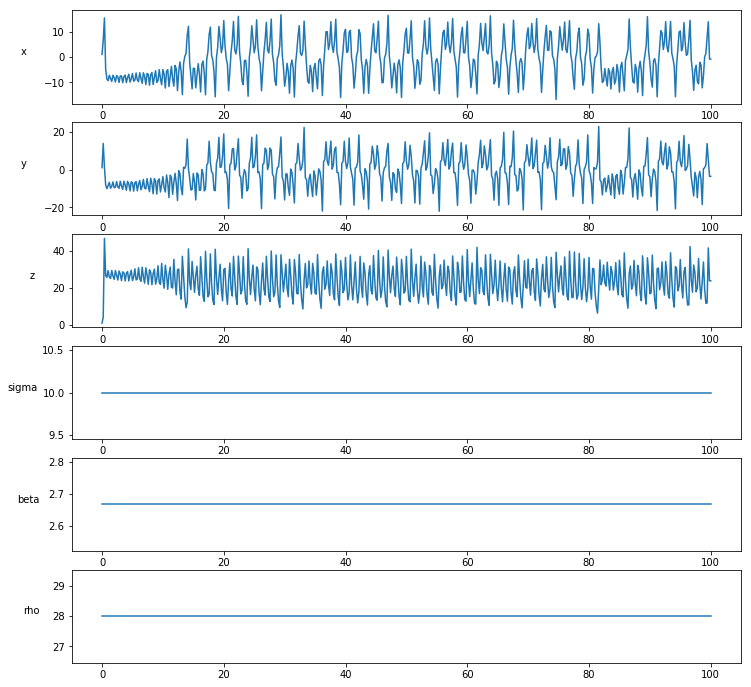

In [16]:
fig, ax = plt.subplots(len(outputs),1,figsize=[12,12])
for i, v in enumerate(outputs):
    try:
        ax[i].plot(res_dym['time'],res_dym[v])
        ax[i].set_ylabel(v,rotation=0,labelpad=20)
    except: 
        pass
fig.savefig(plotPath+'/{}/{}_dymola.png'.format(dymolaComparison,fmu_test),dpi=dpi)

# Result Comparison

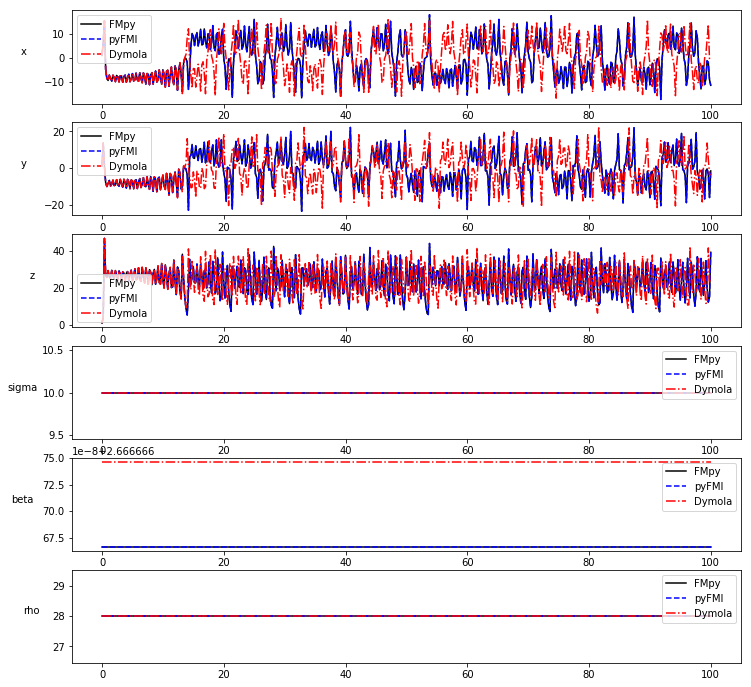

In [17]:
fig, ax = plt.subplots(len(outputs),1,figsize=[12,12])
for i, v in enumerate(outputs):
    ax[i].plot(result['time'],result[v],'k-', label='FMpy')
    ax[i].plot(res_pyfmi['time'],res_pyfmi[v],'b--', label='pyFMI')
    try:
        ax[i].plot(res_dym['time'],res_dym[v],'r-.', label='Dymola')
    except:
        pass
    ax[i].legend()
    ax[i].set_ylabel(v,rotation=0,labelpad=20)
    
fig.savefig(plotPath+'/{}/{}_comparison.png'.format(dymolaComparison,fmu_test),dpi=dpi)

In [23]:
# Run this after running the notebook to save specific results

# import pickle
# data = {}
# data['time']=result['time']
# for i, v in enumerate(outputs):
#     try:
#         data['diff_{}'.format(v)]=result[v]-res_dym[v]
#     except:
#         pass
# with open('temp.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


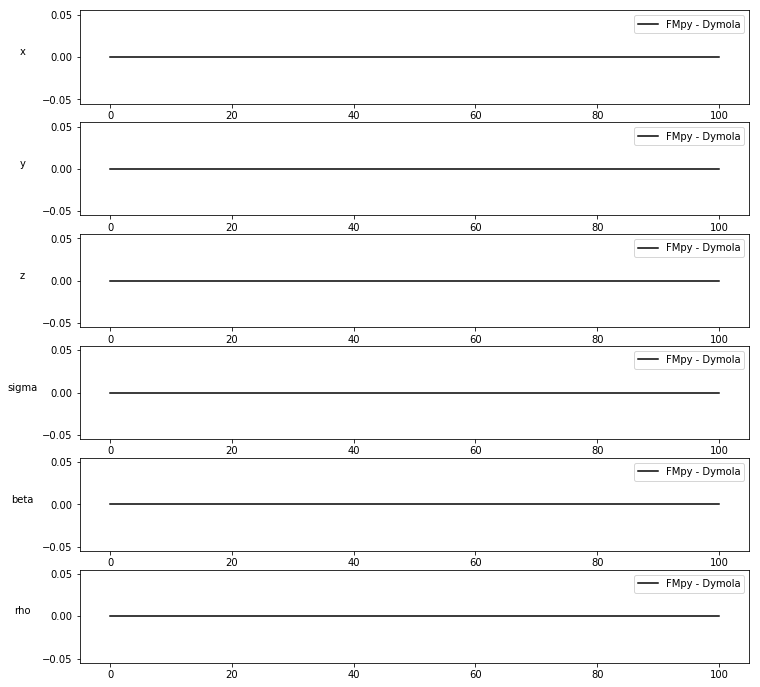

In [31]:
# Run this code to compare a previous run save information with the current run

# import pickle
# with open('temp.pickle', 'rb') as handle:
#     data = pickle.load(handle)
    
# data2 = {}
# data2['time']=result['time']
# for i, v in enumerate(outputs):
#     try:
#         data2['diff_{}'.format(v)]=result[v]-res_dym[v]
#     except:
#         pass
    
# fig, ax = plt.subplots(len(outputs),1,figsize=[12,12])
# for i, v in enumerate(outputs):
#     try:           
#         ax[i].plot(data['time'],data['diff_{}'.format(v)]-data2['diff_{}'.format(v)],'k-', label='FMpy - Dymola')
#     except:
#         pass
#     ax[i].legend()
#     ax[i].set_ylabel(v,rotation=0,labelpad=20)
    
# fig.savefig(plotPath+'/{}_diff_FMUtoFMU_all.png'.format(fmu_test),dpi=dpi)

# Diff between FMU and Dymola

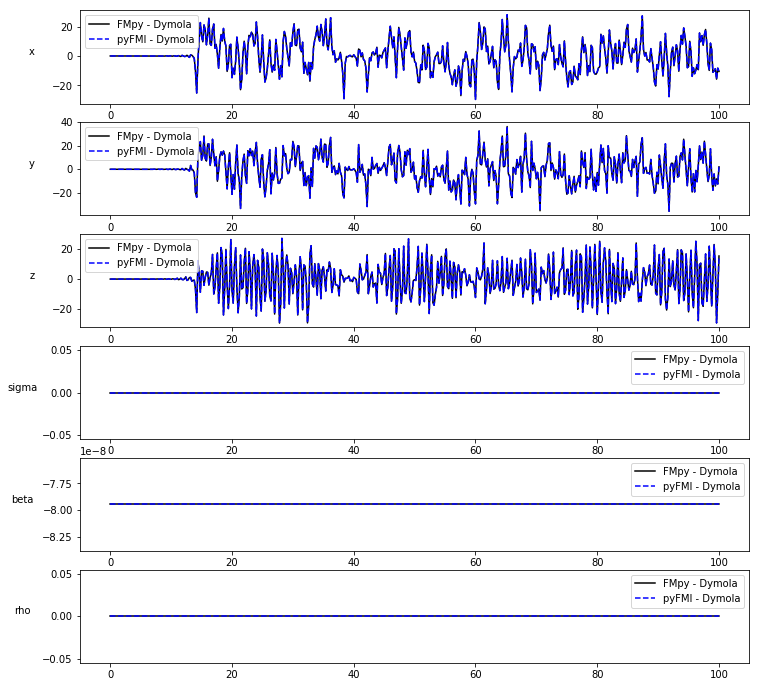

In [20]:
fig, ax = plt.subplots(len(outputs),1,figsize=[12,12])
for i, v in enumerate(outputs):
    try:           
        ax[i].plot(result['time'],result[v]-res_dym[v],'k-', label='FMpy - Dymola')
        ax[i].plot(result['time'],res_pyfmi[v]-res_dym[v],'b--', label='pyFMI - Dymola')
    except:
        pass
    ax[i].legend()
    ax[i].set_ylabel(v,rotation=0,labelpad=20)
    
fig.savefig(plotPath+'/{}/{}_diff_FMUtoDymola.png'.format(dymolaComparison,fmu_test),dpi=dpi)

# Diff between FMUs

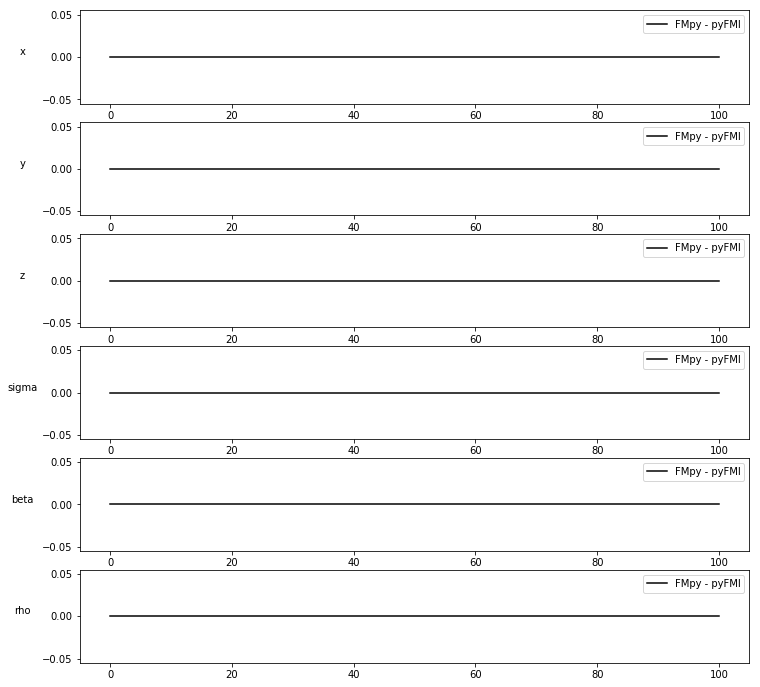

In [21]:
fig, ax = plt.subplots(len(outputs),1,figsize=[12,12])
for i, v in enumerate(outputs):
    try:           
        ax[i].plot(result['time'],result[v]-res_pyfmi[v],'k-', label='FMpy - pyFMI')
    except:
        pass
    ax[i].legend()
    ax[i].set_ylabel(v,rotation=0,labelpad=20)
    
fig.savefig(plotPath+'/{}/{}_diff_FMUtoFMU.png'.format(dymolaComparison,fmu_test),dpi=dpi)

In [22]:
plt.close('all')